# PyTorch Workflow Fundamentals

https://www.learnpytorch.io/01_pytorch_workflow/

ML is generally has two phases

1. Convert your data into numbers (create a representation)
2. Pick or build a model to learn the representation 

We are going to train a model to learn the relationship between **features** (the X axis, our inputs) and **labels** (the Y axis, the expected outputs)

In [62]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

## Create a fake dataset of inputs and expected outputs

The problem we want to solve is given an x-axis value for a curve, the model should predict the y-axis value.

This dataset has:

* 50 input examples (x-axis values)
* 50 corresponding expected outputs (y-axis values)
* 2 parameters which we will give the model to tune. 
 
We tell the model that it has just 2 variables it can find values for to make the inputs match the expected outputs.

The model isn't smart enough to know how many parameters it should have - we have to tell it.

In [63]:
# Use these parameters for the dataset. We expect the model to discover these on it's own
weight = 0.7
bias = 0.3

# Create a set of x-axis values
start = 0
end = 1
step = 0.02

# https://pytorch.org/docs/stable/generated/torch.arange.html?highlight=arange#torch.arange
# arange() returns a 1-D tensor
t = torch.arange(start, end, step, dtype=torch.float64) 
print(f"DEBUG: t tensor shape={t.shape}, rank={t.ndim}, elements={t.numel()}")
#
# returns a new tensor with a dimension of size 1 inserted at the specified position i.e.
#
# input:
# tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
#         0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
#         0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
#         0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
#         0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
#         0.9000, 0.9200, 0.9400, 0.9600, 0.9800], dtype=torch.float64)


# TODO: I don't know why the unsqueeze() here. Everything seems to work fine if you just skip it
X = t.unsqueeze(dim=1)
# unsqueeze(dim=1) wraps each value in the first dimension (dimensions start at 0) in another array
# It returns:
# tensor([[0.0000],
#         [0.0200],
#         [0.0400],
#         [0.0600],
#         [0.0800],
#         [0.1000],
#         [0.1200]
#					...
#
print(f"DEBUG: X tensor shape={X.shape}, rank={X.ndim}, elements={X.numel()}")


# Q: why do we unsqueeze?

# create a new tensor y by multiplying scalar (rank=0 tensor) weight and bias
y = weight * X + bias
print(f"DEBUG: y tensor shape={y.shape}, rank={y.ndim}, elements={y.numel()}")

# y = labels
# X = features

# We know the exact relationship between X and y because we created the weight and bias parameters.
# We want to see how well our model can learn the relationship between X and y based on the examples alone.

# show a sample of each tensor
X[:10], y[:10]


DEBUG: t tensor shape=torch.Size([50]), rank=1, elements=50
DEBUG: X tensor shape=torch.Size([50, 1]), rank=2, elements=50
DEBUG: y tensor shape=torch.Size([50, 1]), rank=2, elements=50


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]], dtype=torch.float64),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]], dtype=torch.float64))

## Split the data into training, validation, testing sets

Now we have a data set of training examples aka features (each element in X tensor) and the expected output for each training example (each element in y tensor).

We need to split our training examples into sets

1. Training set (60-80% of total data)
	* The model learns from this data
2. Validation set (10-20% of total data)
	* The model gets tuned on this dta
	* This set is not always required
3. Testing set (10-20% of total data)
	* The model gets evaluated on this data which it has not seen before
	* This allows us to test how well the model _generalises_ to data it has not seen

In [64]:
# we are choosing an 80/20 training/testing split with no validation set
split_idx = int(0.8 * len(X))

X_train = X[:split_idx] 
X_test = X[split_idx:]
y_train = y[:split_idx] 
y_test = y[split_idx:]

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

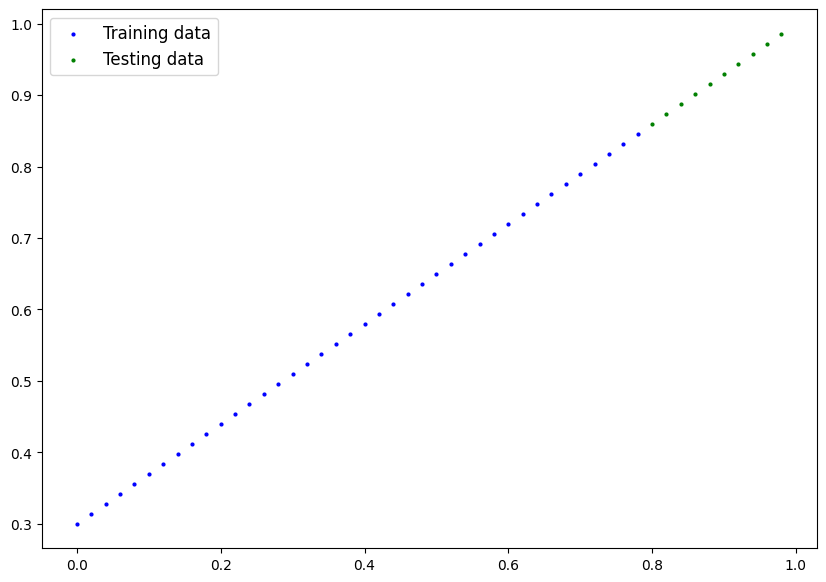

In [65]:
# Create a function to plot our data so we humans can visualise it

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 12});

plot_predictions()

Unsurprisingly the data fits a straight line **very** well because we defined it that way. We are going to see how well the model can figure this out.

## Create the model

In [66]:
# Create a model to do linear regression


# nn.Module is the base class of models in pytorch. It requires a forward() method
class LinearRegressionModel(nn.Module):
	def __init__(self) -> None:
		super().__init__()
		# create a kind of Tensor that is to be considered a module parameter.
		# pytorch likes float32 by default - why?

		# create 1D tensors which can be considered parameters. They are initially filled with random values.
		# requires_grad=True causes pytorch to track the gradients of this parameter  
		self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) # e.g. tensor([0.8786])
		self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) # e.g. tensor([0.8786])

	# forward() defines the computation in the model
	# TODO: better name for x
	# TODO: I _think_ x is the whole training set or testing set. The whole set is passed through every time we call forward
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		# use the linear regression fomula to 
		# x is the input data - the training features
		print("\n\nSTART forward()")
		print(f"forward() input shape: {x.shape}")
		print(f"forward() input: {x}")
		print(f"forward() weights shape: {self.weights.shape}")
		print(f"forward() weights: {self.weights}")
		print(f"forward() bias shape: {self.bias.shape}")
		print(f"forward() bias: {self.bias}")

		# self.weights and self.bias are tensors with shape [1]. 
		# x is tensor with shape [40]
		# so weights and bias are "exploded" up to be shape [40]
		output = self.weights * x + self.bias

		print(f"forward() output shape: {output.shape}")
		print(f"forward() output: {output}")
		print("END forward()")
		return output

In [67]:
# Set a manual seed because our nn.Parameter are randomly initialized
# huh?
torch.manual_seed(42)

# create the model
model_0 = LinearRegressionModel()

# check the parameters are as expected
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [68]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Our goal is for our model to learn better values for the weights and bias parameters through observing the examples



START forward()
forward() input shape: torch.Size([10, 1])
forward() input: tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]], dtype=torch.float64)
forward() weights shape: torch.Size([1])
forward() weights: Parameter containing:
tensor([0.3367], requires_grad=True)
forward() bias shape: torch.Size([1])
forward() bias: Parameter containing:
tensor([0.1288], requires_grad=True)
forward() output shape: torch.Size([10, 1])
forward() output: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)
END forward()
Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
     

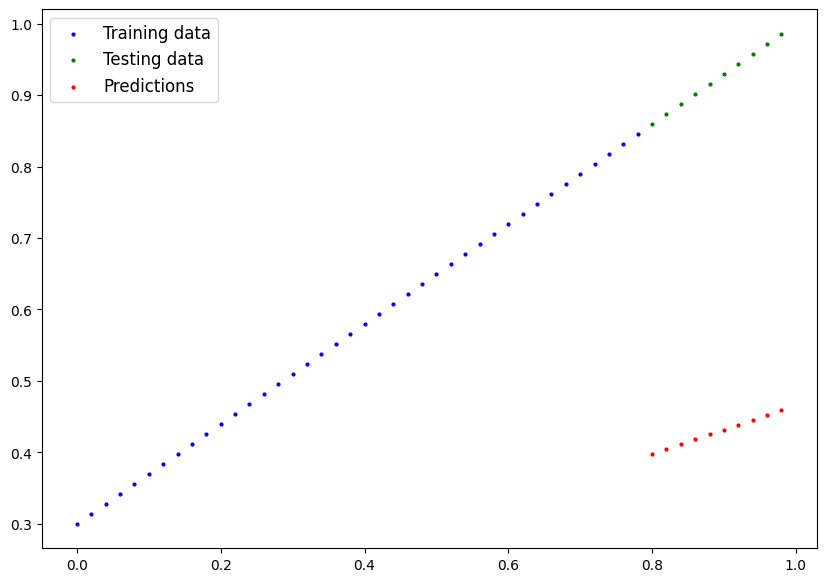

In [69]:
# torch.inference_mode() 
# * turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.
# * returns an object which implements the context manager protocol (`__enter__()` and `__exit__()` methods)
#
with torch.inference_mode():
	# we get the predictions tensor by just passing the test tensor to the model
	# this runs X_test through the forward() function once
	y_preds = model_0(X_test)

print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

plot_predictions(predictions=y_preds)


In [70]:
# roughly check how much our predictions are off (smaller diff = better prediction)
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]], dtype=torch.float64)

## The training loop

In [77]:
# things set by humans are called hyperparameters

# Q: do I have one training example (a 40 wide tensor) or do I have 40 training examples (each example is a single number)?

# use MAE loss function
loss_fn = nn.L1Loss() 

# create optimizer instance
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

epochs = 5 # 300
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
	# Training
	print(f"START TRAIN epoch {epoch}")
	model_0.train() # put model in training mode

	# run the whole set of input values through the model
	y_pred = model_0(X_train)
	# print("-------------")
	# print(y_pred)

	# Calculate the loss between the predictions the model made and the action expected values
	# loss is a tensor which contains a single float. The tensor has a grad_fn attribute which is a reference to the grad_fn of 
	#
	# y_train.grad_fn: None
	# y_pred.grad_fn; AddBackward0 0x15ec
	# loss.grad_fn; AddBackward0 0x15f1
	#
	loss = loss_fn(y_pred, y_train)
	print(f"Training Loss: {loss}")
	print(f"Training Loss shape: {loss.shape}")

	# Do magic ...
	print("Start magic")
	# somewhere in these 3 lines the weight and bias model params get updated ...
	# Q: the loss_fn does not seem to be connected to the optimzer? what is happening here?
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	print("End magic")
	
	# We are testing the model on every training iteration but it looks like we only use the values every 10th
	print("START TEST")
	model_0.eval() # put model in evaluation mode

	with torch.inference_mode():
		# Do one forward pass on test data
		test_pred = model_0(X_test)

		# Calculate the loss on test data
		# predictions are torch.float type so the test data needs to be coerced to be the same
		test_loss = loss_fn(test_pred, y_test.type(torch.float))
		print(f"Test Loss: {test_loss}")
		print(f"Test Loss shape: {test_loss.shape}")

		# capture progress data for later graphing
		if epoch % 10 == 0:
			epoch_count.append(epoch)
			train_loss_values.append(loss.detach().numpy())
			test_loss_values.append(test_loss.detach().numpy())
			print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")



START TRAIN epoch 0


START forward()
forward() input shape: torch.Size([40, 1])
forward() input: tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800]], dtype=torch.float64)
forward() weights shape: torch.Size([1])
forward() weights: Parameter containing:
tensor([0.3562], requires_grad=True)
forward() bias shape: torch.Size([1])
for

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


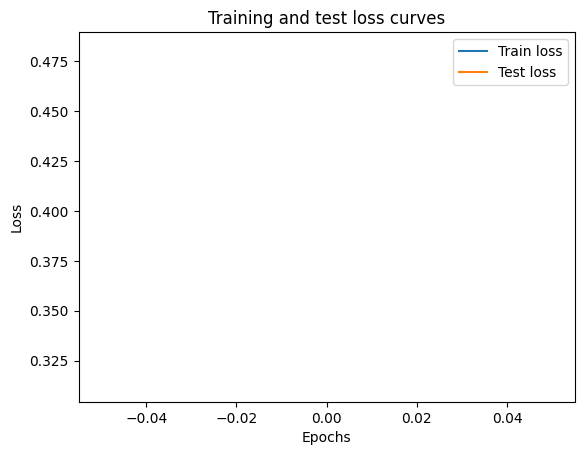

In [72]:
# Now training is finished we print some summary of it's progress
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")



START forward()
forward() input shape: torch.Size([10, 1])
forward() input: tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]], dtype=torch.float64)
forward() weights shape: torch.Size([1])
forward() weights: Parameter containing:
tensor([0.3562], requires_grad=True)
forward() bias shape: torch.Size([1])
forward() bias: Parameter containing:
tensor([0.1788], requires_grad=True)
forward() output shape: torch.Size([10, 1])
forward() output: tensor([[0.4638],
        [0.4709],
        [0.4780],
        [0.4851],
        [0.4923],
        [0.4994],
        [0.5065],
        [0.5136],
        [0.5208],
        [0.5279]], dtype=torch.float64)
END forward()


tensor([[0.4638],
        [0.4709],
        [0.4780],
        [0.4851],
        [0.4923],
        [0.4994],
        [0.5065],
        [0.5136],
        [0.5208],
        [0.5279]], dtype=torch.float64)

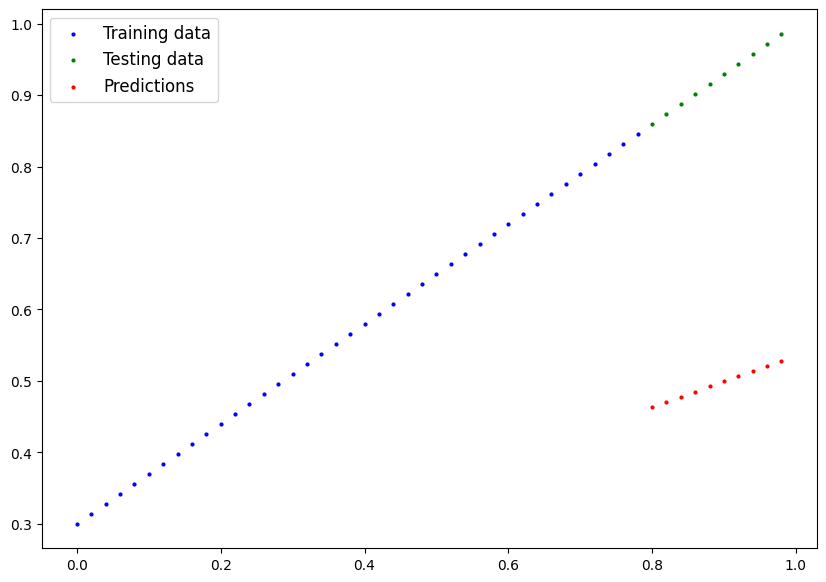

In [73]:
# Make some predictions with our trained model

# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)
y_preds


In [74]:
# The recommended way to save a model for inference is to save and load the model's state_dict()

from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth




START forward()
forward() input shape: torch.Size([10, 1])
forward() input: tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]], dtype=torch.float64)
forward() weights shape: torch.Size([1])
forward() weights: Parameter containing:
tensor([0.3562], requires_grad=True)
forward() bias shape: torch.Size([1])
forward() bias: Parameter containing:
tensor([0.1788], requires_grad=True)
forward() output shape: torch.Size([10, 1])
forward() output: tensor([[0.4638],
        [0.4709],
        [0.4780],
        [0.4851],
        [0.4923],
        [0.4994],
        [0.5065],
        [0.5136],
        [0.5208],
        [0.5279]], dtype=torch.float64)
END forward()


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

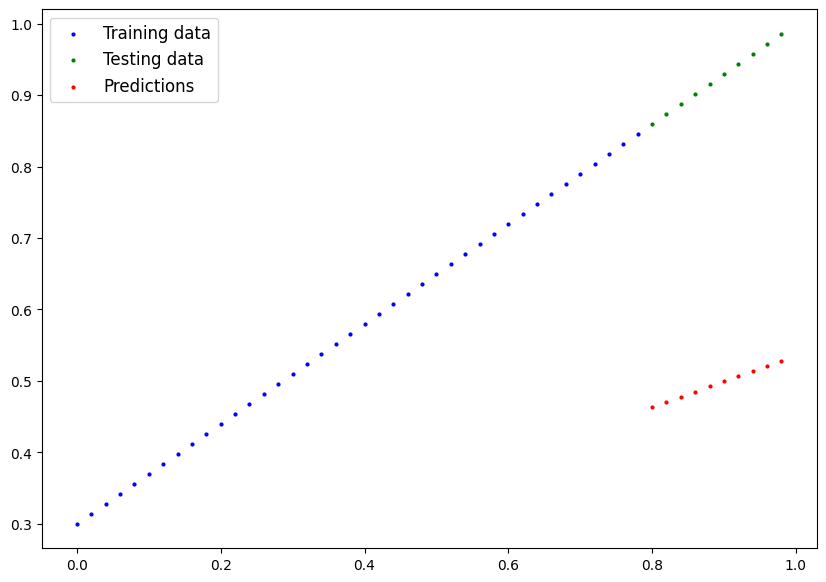

In [75]:
# Now load a saved model

# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

plot_predictions(predictions=loaded_model_preds)

# The loaded model makes exactly the same predictions as our original
y_preds == loaded_model_preds

In [76]:
# No point in messing iwth the cuda stuff because it won't work on my mac
torch.cuda.is_available() 

False